In [1]:
import pandas as pd
import numpy as np

In [3]:
#Import US DOT insurance history dataset

path = "inshist_allwithhistory.txt"

ins = pd.read_csv(
    path,
    header=None,        
    dtype=str,          
    sep=",",            
    quotechar='"',      
    engine="python",
)
ins.shape

(7135188, 17)

In [5]:
#Change column names (based off of codebook)

ins = ins.rename(columns={
    0: "docket_number",
    1: "usdot_number",
    2: "form_code",
    3: "cancellation_method",
    4: "form_type",
    5: "insurance_type_indicator",
    6: "insurance_type_description",
    7: "policy_number",
    8: "minimum_coverage_amount",
    9: "insurance_class_code",
    10: "effective_date",
    11: "bi_pd_max_underlying_limit_amt",
    12: "bi_pd_max_coverage_amt",
    13: "cancellation_date",
    14: "specific_cancellation_method",
    15: "insurance_company_branch",
    16: "insurance_company_name"
})

In [9]:
# =========================
# Helpers / Normalization
# =========================
def _safe_str_series(s, dtype="string"):
    """Return a string-typed Series even if s is missing; preserves index length when possible."""
    if s is None:
        return pd.Series(index=pd.RangeIndex(0), dtype=dtype)  # empty placeholder
    return pd.Series(s, dtype=dtype)

def map_form_category(code: str) -> str | None:
    if code is None or code == "" or code is pd.NA:
        return None
    c = str(code).upper()
    if c in {"34", "83"}:
        return "Cargo"
    if c in {"82", "91", "91X"}:
        return "BIPD"
    if c == "84":
        return "BrokerBond"
    if c == "85":
        return "BrokerTrust"
    return None  # ignore other / unknown codes


# ======================================================
# Start from your original DataFrame: `ins`
# (Assumes `ins` exists in memory already)
# ======================================================
# --- Base copy and cleaning ---
ins2 = ins.copy()

# Ensure USDOT ID is usable
ins2["usdot_number"] = ins2["usdot_number"].astype(str).str.strip()
ins2 = ins2[ins2["usdot_number"] != "00000000"]

# Dates -> datetime (idempotent)
for col in ["effective_date", "cancellation_date"]:
    if col in ins2.columns and not pd.api.types.is_datetime64_any_dtype(ins2[col]):
        ins2[col] = pd.to_datetime(ins2[col], errors="coerce")

# Normalize text columns (robustly)
ins2["cancellation_method"] = (
    ins2.get("cancellation_method", pd.Series(index=ins2.index, dtype="string"))
       .astype("string").str.strip().str.title()
)

ins2["insurance_company_name"] = (
    ins2.get("insurance_company_name", pd.Series(index=ins2.index, dtype="string"))
       .astype("string").str.strip()
)

ins2["form_code"] = (
    ins2.get("form_code", pd.Series(index=ins2.index, dtype="string"))
       .astype("string").str.strip().str.upper()
)

# --- Core tallies ---
tot  = ins2.groupby("usdot_number").size()

fmin = ins2.groupby("usdot_number")["effective_date"].min()
fmax = ins2.groupby("usdot_number")["effective_date"].max()

# Counts by insurance company
pc = ins2.groupby(["usdot_number", "insurance_company_name"]).size()

num_unique_companies = pc.groupby(level=0).size() if not pc.empty else tot * 0
top_company_count    = pc.groupby(level=0).max() if not pc.empty else tot * 0
top_company          = (
    pc.groupby(level=0).idxmax().map(lambda k: k[1]) if not pc.empty else pd.Series(index=tot.index, dtype="string")
)
top_company_share    = (top_company_count / tot).fillna(0).astype(float)

# All company names (sorted, unique, comma-joined)
if not pc.empty:
    all_companies = (
        pc.reset_index()
          .groupby("usdot_number")["insurance_company_name"]
          .apply(lambda s: ", ".join(sorted(pd.unique(s.dropna().astype(str)))))
    )
else:
    all_companies = pd.Series(index=tot.index, dtype="string")

# Unique docket numbers + list
if "docket_number" in ins2.columns:
    docket_unique_count = ins2.groupby("usdot_number")["docket_number"].nunique(dropna=True)
    all_dockets = (
        ins2.assign(_d=ins2["docket_number"].astype("string"))
            .groupby("usdot_number")["_d"]
            .apply(lambda s: ", ".join(sorted([d for d in pd.unique(s.dropna()) if d != ""])))
    )
else:
    docket_unique_count = pd.Series(0, index=tot.index, dtype="int64")
    all_dockets = pd.Series(index=tot.index, dtype="string")

# Change method counts (normalized labels)
def _count_method(label: str) -> pd.Series:
    return (ins2["cancellation_method"].eq(label)).groupby(ins2["usdot_number"]).sum().reindex(tot.index, fill_value=0)

cancelled_ct = _count_method("Cancelled")
replaced_ct  = _count_method("Replaced")
namechg_ct   = _count_method("Name Changed")
transfer_ct  = _count_method("Transferred")

# --- Map form codes to categories, then count per DOT ---
form_cat = ins2["form_code"].map(map_form_category)
fc_counts = (
    ins2.assign(_cat=form_cat)
        .dropna(subset=["_cat"])
        .groupby(["usdot_number", "_cat"])
        .size()
        .unstack("_cat", fill_value=0)
    if "form_code" in ins2.columns else pd.DataFrame(index=tot.index)
)

# Ensure expected columns exist
for col in ["Cargo", "BIPD", "BrokerBond", "BrokerTrust"]:
    if col not in fc_counts.columns:
        fc_counts[col] = 0

fc_counts = (
    fc_counts[["Cargo", "BIPD", "BrokerBond", "BrokerTrust"]]
      .rename(columns={
          "Cargo": "count_cargo",
          "BIPD": "count_bipd",
          "BrokerBond": "count_broker_bond",
          "BrokerTrust": "count_broker_trust_fund"
      })
      .reindex(tot.index, fill_value=0)
)

# ======================================================
# Gaps: overall (any method) via diff of effective_date
# ======================================================
# Sort for consecutive diffs per usdot
ins2_sorted = ins2.sort_values(["usdot_number", "effective_date"], kind="mergesort")

# Optional dedupe: if multiple filings per-day are noise, uncomment:
# ins2_sorted = ins2_sorted.drop_duplicates(subset=["usdot_number", "effective_date"])

gap_days = (
    ins2_sorted
        .groupby("usdot_number", sort=False)["effective_date"]
        .diff()
        .dt.days
)
ins2_sorted = ins2_sorted.assign(_gap_days=gap_days)

gap_stats = (
    ins2_sorted
        .dropna(subset=["_gap_days"])  # drop first-in-sequence and invalids
        .groupby("usdot_number")["_gap_days"]
        .agg(
            min_gap_days="min",
            max_gap_days="max",
            median_gap_days="median",
            avg_gap_days="mean",
            p25_gap_days=lambda s: s.quantile(0.25, interpolation="linear"),
            p75_gap_days=lambda s: s.quantile(0.75, interpolation="linear"),
        )
)

# Tidy types/rounding
for c in ["avg_gap_days", "median_gap_days", "p25_gap_days", "p75_gap_days"]:
    if c in gap_stats.columns:
        gap_stats[c] = gap_stats[c].astype(float).round(2)
for c in ["min_gap_days", "max_gap_days"]:
    if c in gap_stats.columns:
        gap_stats[c] = gap_stats[c].astype("int64")


# ======================================================
# Option 2: Gaps between ANY filings, labeled by the LATER method
# ======================================================
to_next = (
    ins2_sorted
      .dropna(subset=["_gap_days"])
      .dropna(subset=["cancellation_method"])  # need a label for the later filing
      .copy()
)

to_next_gap_stats = (
    to_next
      .groupby(["usdot_number", "cancellation_method"])["_gap_days"]
      .agg(
          min_gap_to="min",
          max_gap_to="max",
          median_gap_to="median",
          avg_gap_to="mean",
          p25_gap_to=lambda s: s.quantile(0.25, interpolation="linear"),
          p75_gap_to=lambda s: s.quantile(0.75, interpolation="linear"),
      )
)

# Round float-like stats
for c in ["avg_gap_to", "median_gap_to", "p25_gap_to", "p75_gap_to"]:
    if c in to_next_gap_stats.columns:
        to_next_gap_stats[c] = to_next_gap_stats[c].astype(float).round(2)

# Pivot wide -> columns like median_gap_to_cancelled, ...
to_next_gap_stats_wide = to_next_gap_stats.unstack("cancellation_method")

# Flatten MultiIndex columns
to_next_gap_stats_wide.columns = [
    f"{stat}_{str(method).lower().replace(' ', '_')}"
    for stat, method in to_next_gap_stats_wide.columns
]

# Optional: counts of labeled gaps used per method (quality-of-sample indicator)
to_next_n_wide = (
    to_next
      .groupby(["usdot_number", "cancellation_method"])["_gap_days"]
      .size()
      .unstack("cancellation_method")
      .rename(columns=lambda m: f"n_gaps_to_{str(m).lower().replace(' ', '_')}")
)

# Cast min/max to nullable ints (they can be NaN when insufficient data)
for c in list(to_next_gap_stats_wide.columns):
    if c.startswith("min_gap_to_") or c.startswith("max_gap_to_"):
        to_next_gap_stats_wide[c] = to_next_gap_stats_wide[c].astype("Int64")


# =====================================
# Assemble final summary (one row per DOT)
# =====================================
summary = (
    pd.DataFrame({
        "num_filings": tot,
        "num_unique_companies": num_unique_companies,
        "top_company": top_company,
        "top_company_share": top_company_share,
        "cancelled_method_count": cancelled_ct,
        "replaced_method_count": replaced_ct,
        "name_changed_method_count": namechg_ct,
        "transferred_method_count": transfer_ct,
        "first_filing_date": fmin,
        "last_filing_date": fmax,
        "docket_unique_count": docket_unique_count,
        "all_dockets": all_dockets,
        "all_companies": all_companies,
    })
    .join(fc_counts, how="left")
    .join(gap_stats, how="left")                 # overall gaps (any method)
    .join(to_next_gap_stats_wide, how="left")    # Option 2 gaps by later method
    .join(to_next_n_wide, how="left")            # counts per later method
    .fillna({
        "cancelled_method_count": 0,
        "replaced_method_count": 0,
        "name_changed_method_count": 0,
        "transferred_method_count": 0,
        "count_cargo": 0,
        "count_bipd": 0,
        "count_broker_bond": 0,
        "count_broker_trust_fund": 0,
        "docket_unique_count": 0
    })
    .reset_index()
    .sort_values(["num_unique_companies", "num_filings"], ascending=[False, False])
)

# Cast integer-like columns where safe
int_cols = [
    "num_filings", "num_unique_companies",
    "cancelled_method_count", "replaced_method_count",
    "name_changed_method_count", "transferred_method_count",
    "count_cargo", "count_bipd", "count_broker_bond", "count_broker_trust_fund",
    "docket_unique_count",
]
for col in int_cols:
    if col in summary.columns:
        summary[col] = summary[col].astype("int64")

# --- Done ---
# summary now includes:
# - overall gap stats: min/max/median/avg/p25/p75 (any method)
# - Option 2 per-method stats: min/max/median/avg/p25/p75 gaps TO each method
# - n_gaps_to_<method>: count of labeled gaps contributing to those stats


In [17]:
# Export to parquet
summary.to_parquet("insurance_summary.parquet")

In [52]:
census = pd.read_csv("SMS_Input_-_Motor_Carrier_Census_Information_20250919.csv")

In [54]:
"""
# insurance dataset: strip leading zeros
ins_ids = summary["usdot_number"].astype(str).str.lstrip("0")

# other dataset: also cast to string (strip spaces just in case)
census_ids = census["DOT_NUMBER"].astype(str).str.strip()

# now compare as sets
a = set(ins_ids)
b = set(census_ids)

matches = a & b
only_ins = a - b
only_other = b - a

output = {
    "match_in_both": len(matches),
    "only_in_insurance": len(only_ins),
    "only_in_other": len(only_other),
    "total_insurance": len(a),
    "total_other": len(b),
}
output
"""

{'match_in_both': 432175,
 'only_in_insurance': 753548,
 'only_in_other': 1659468,
 'total_insurance': 1185723,
 'total_other': 2091643}

In [56]:
# Merge insurance data with census data
def make_dot_key(s):
    return (
        s.astype(str)
         .str.strip()
         .str.lstrip("0")
         .replace("", pd.NA)
    )

census_key  = make_dot_key(census["DOT_NUMBER"])
summary_key = make_dot_key(summary["usdot_number"])

census2  = census.assign(_DOT_KEY=census_key)
summary2 = summary.assign(_DOT_KEY=summary_key)

# Left-join census
merged = census2.merge(
    summary2,
    on="_DOT_KEY",
    how="left",
    suffixes=("_census", "_summary"),
    validate="m:1"
)

# Sanity check that merge occurred correctly
matched_rows   = merged["num_filings"].notna().sum()
unmatched_rows = merged["num_filings"].isna().sum()
total_rows     = len(merged)

matched_rows, unmatched_rows, total_rows


(432175, 1659468, 2091643)

In [58]:
merged

merged.to_parquet("insurance_with_census.parquet", index=False)

#export to csv

#merged.to_csv("census_with_insurance.csv", index=False)

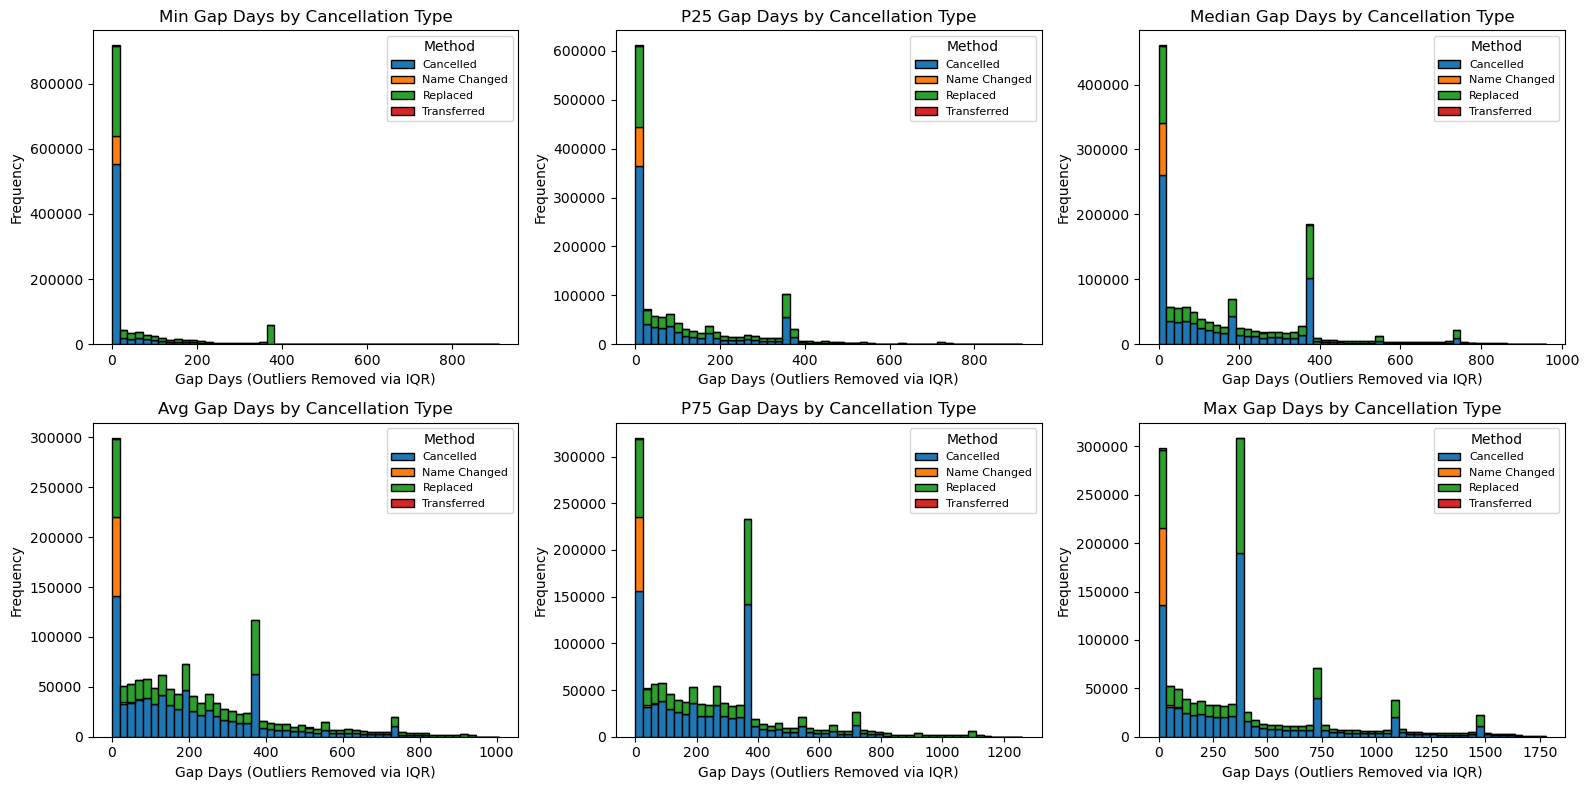

In [37]:
"""
#Summary graphs
import matplotlib.pyplot as plt

# Define the six stats you want to visualize
stats = ["min", "p25", "median", "avg", "p75", "max"]

# Identify all relevant columns in your dataset
all_cols = summary.columns

# Build mapping from stat -> list of per-method columns for that stat
stat_cols = {
    stat: [c for c in all_cols if c.startswith(f"{stat}_gap_to_")]
    for stat in stats
}

# Function to IQR-filter a pandas Series
def iqr_filter(series):
    x = series.dropna()
    if len(x) < 2:
        return x
    Q1, Q3 = x.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return x[(x >= lower) & (x <= upper)]

# Set up grid: 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
axes = axes.flatten()

# Loop through each stat and plot a stacked histogram
for i, stat in enumerate(stats):
    cols = stat_cols.get(stat, [])
    if not cols:
        continue

    # Apply IQR filtering within each per-method column
    filtered_data = {}
    for c in cols:
        x = summary[c].dropna()
        if len(x) == 0:
            continue
        filtered_data[c] = iqr_filter(x)

    # Prepare data and labels
    data_to_plot = [filtered_data[c] for c in filtered_data]
    labels = [c.replace(f"{stat}_gap_to_", "").replace("_", " ").title()
              for c in filtered_data]

    # Plot stacked histogram in this subplot
    ax = axes[i]
    ax.hist(data_to_plot, bins=50, stacked=True, edgecolor='black', label=labels)
    ax.set_title(f"{stat.title()} Gap Days by Cancellation Type")
    ax.set_xlabel("Gap Days (Outliers Removed via IQR)")
    ax.set_ylabel("Frequency")
    ax.legend(title="Method", fontsize=8)

# Adjust layout for readability
plt.tight_layout()
plt.show()
"""

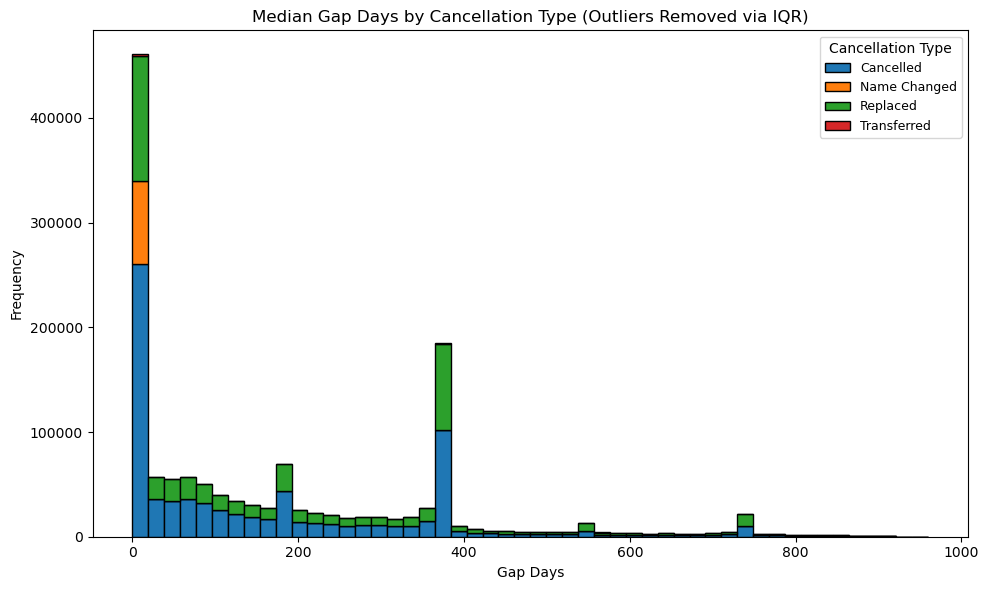

In [17]:
"""
# --- Focus only on the median columns ---
median_cols = [c for c in summary.columns if c.startswith("median_gap_to_")]

def iqr_filter(series):
    """Remove outliers using the 1.5*IQR rule."""
    x = series.dropna()
    if len(x) < 2:
        return x
    Q1, Q3 = x.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return x[(x >= lower) & (x <= upper)]

# Prepare filtered data per method
filtered_data = {}
for c in median_cols:
    x = summary[c].dropna()
    if len(x) == 0:
        continue
    filtered_data[c] = iqr_filter(x)

# Plot single stacked histogram
plt.figure(figsize=(10, 6))
plt.hist(
    [filtered_data[c] for c in filtered_data],
    bins=50,
    stacked=True,
    edgecolor="black",
    label=[c.replace("median_gap_to_", "").replace("_", " ").title() for c in filtered_data]
)
plt.title("Median Gap Days by Cancellation Type (Outliers Removed via IQR)")
plt.xlabel("Gap Days")
plt.ylabel("Frequency")
plt.legend(title="Cancellation Type", fontsize=9)
plt.tight_layout()


plt.savefig("median_gap_hist.png", dpi=300, bbox_inches="tight")
plt.show()
"""